Learning the basics of neural nets by implementing basic algos from scratch. This notebook is used to test and demo matrixgrad.py. It is is based on Andrej Karpathy's https://github.com/karpathy/micrograd applied to 2d numpy arrays; so kind of a blend of his micrograd and backprop ninja online classes in https://karpathy.ai/zero-to-hero.html

First, let's test and look at the autograd layer in matrixgrad.py. The code below creates a graph function to visualize a DAG of Matrix classes and uses that to visualize the graph created by performing operations on Matrices

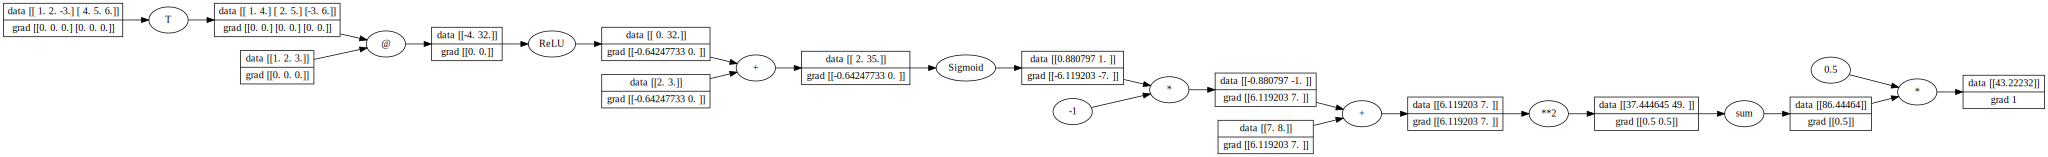

MatrixGrad and PyTorch autograds match for sigmoid(relu(x @ w) + b)


In [6]:
from matrixgrad import Matrix, sigmoid, relu
import numpy as np

from graphviz import Digraph
def graph(self, details=True):
    def trace(root):
        nodes, edges = set(), set()
        def build(v):
            if v not in nodes:
                nodes.add(v)
                if isinstance(v, Matrix):
                    for child in v._prev:
                        edges.add((child, v))
                        build (child)
        build(root)
        return nodes, edges
    
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(self)
    for n in nodes:
        uid = str(id(n))
        if not isinstance(n, Matrix):
            dot.node(name=uid, label = str(n), shape="oval")
        else:
            if details:
                dot.node(name=uid, label = f"data {n.data} | grad {n.grad}", shape="record")
            else:
                dot.node(name=uid, label = f"data {n.data.shape}", shape="record")
            if n._op:
                dot.node(name = uid + n._op, label = n._op)
                dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


# Do the auto-grad thing with the Matrix class
w = Matrix([[1,2,-3],[4,5,6]]).transpose()
b = Matrix([2,3])
x = Matrix([1,2,3])
y = Matrix([7, 8])
y_hat = sigmoid(relu(x @ w) + b)
loss = ((y-y_hat)**2).sum()/y.shape[1]
loss.backward()
display (graph(loss))

# Now try the same thing with PyTorch
import torch
t_x = torch.tensor(x.data, dtype=torch.float32)
t_w = torch.tensor(w.data, dtype=torch.float32, requires_grad=True)
t_b = torch.tensor(b.data, dtype=torch.float32, requires_grad=True)
t_y_hat = torch.sigmoid(torch.relu(t_x @ t_w) + t_b)
t_loss = torch.nn.MSELoss()(torch.as_tensor(y.data), t_y_hat)
t_loss.backward()

# Make sure they are the same
assert np.allclose(y_hat.data, t_y_hat.data.numpy()), f"Matrix y_hat {y_hat.data} != torch y_hat {t_y_hat.data}"
assert np.allclose(w.grad, t_w.grad.data.numpy()), f"Matrix grad {w.grad} != torch grad {t_w.grad}"
assert np.allclose(b.grad, t_b.grad.data.numpy()), f"Matrix grad {b.grad} != torch grad {t_b.grad}"

print ("MatrixGrad and PyTorch autograds match for sigmoid(relu(x @ w) + b)")


Next, let's look at how Modules (build on top of Values) can be built run.
We'll visualize the models and gradiants with digraph.
We'll compare the forward and backward pass values with those generated by PyTorch to validate the Matrix code.

MatrixGrad and PyTorch forward and backward pass match for mse loss of Matix operations
Model: Sequential([Layer(inputs=2, outputs=4), ReLU, Layer(inputs=4, outputs=3)])
MatrixGrad and PyTorch forward and backward pass match for mse loss on a sequential model


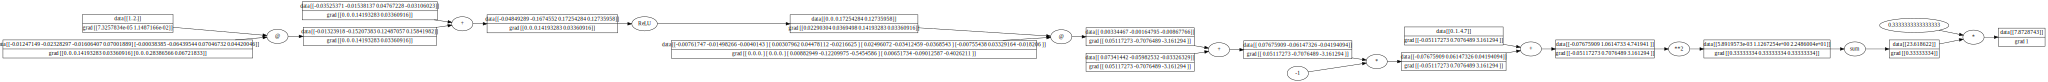

In [9]:
# Simple 3-layer model, internally using Value objects as weights for the linear layers
from matrixgrad import Linear, ReLU, Sequential, mse_loss
import numpy as np

""" Test the classes defined in this file """
l = Linear(2, 3)
x = np.array([[1.0, 2.0]])
y = np.array([[0.0, 1.0, 4.7]])
yhat = l(x)
yhat_relu = relu(yhat)
loss = mse_loss([y], [yhat_relu])
loss.backward()

import torch
t_l = torch.nn.Linear(2, 3)
t_l.weight.data = torch.tensor(l.w.data.T)
t_l.bias.data = torch.tensor(l.b.data)
t_x = torch.tensor(x, dtype=torch.float32)
t_y = torch.tensor(y, dtype=torch.float32)
t_yhat = t_l(t_x)
t_yhat_relu = torch.nn.ReLU()(t_yhat)
t_loss = torch.nn.MSELoss()(t_y, t_yhat_relu)
t_loss.backward()

assert np.allclose(yhat.data, t_yhat.data), "Linear layer output doesn't match PyTorch"
assert np.allclose(yhat_relu.data, t_yhat_relu.data), "ReLU output doesn't match PyTorch"
assert np.allclose(loss.data, t_loss.data), "MSE loss doesn't match PyTorch"
assert np.allclose(l.w.grad, t_l.weight.grad.T), "Linear layer weight gradient doesn't match PyTorch"
assert np.allclose(l.b.grad, t_l.bias.grad), "Linear layer bias gradient doesn't match PyTorch"

print ("MatrixGrad and PyTorch forward and backward pass match for mse loss of Matix operations")

# Now lets try the same thing with a Sequential model
model = Sequential([Linear(2, 4), ReLU(), Linear(4, 3)])
yhat = model(x)
loss = mse_loss([y], [yhat])
loss.backward()
print (f"Model: {model}")

t_model = torch.nn.Sequential(torch.nn.Linear(2, 4), torch.nn.ReLU(), torch.nn.Linear(4, 2))
t_model[0].weight.data = torch.tensor(model.layers[0].w.data.T)
t_model[0].bias.data = torch.tensor(model.layers[0].b.data)
t_model[2].weight.data = torch.tensor(model.layers[2].w.data.T)
t_model[2].bias.data = torch.tensor(model.layers[2].b.data)
t_yhat = t_model(t_x)
t_loss = torch.nn.MSELoss()(t_y, t_yhat)
t_loss.backward()

assert np.allclose(yhat.data, t_yhat.data), "Sequential model output doesn't match PyTorch"
assert np.allclose(loss.data, t_loss.data), "MSE loss doesn't match PyTorch"
assert np.allclose(model.layers[0].w.grad, t_model[0].weight.grad.T), "Linear layer weight gradient doesn't match PyTorch"
assert np.allclose(model.layers[0].b.grad, t_model[0].bias.grad), "Linear layer bias gradient doesn't match PyTorch"
assert np.allclose(model.layers[2].w.grad, t_model[2].weight.grad.T), "Linear layer weight gradient doesn't match PyTorch"
assert np.allclose(model.layers[2].b.grad, t_model[2].bias.grad), "Linear layer bias gradient doesn't match PyTorch"

print ("MatrixGrad and PyTorch forward and backward pass match for mse loss on a sequential model")
display(graph(loss))


Next, let's try training with the layers that sit on top of the Matrix/autograd layer

In [21]:
from matrixgrad import Matrix, Sequential, Linear, ReLU, mse_loss, SGD, fit, SGDRLR
import numpy as np

np.random.seed(12)  # 12th man - go Seahawks!

""" Train a model to learn the function f(x1,x2) = x1+x2+1 with SGD and verify the fit """
x_train = [Matrix([[np.random.uniform(-1, 1), np.random.uniform(-1, 1)]]) for _ in range(50)]
y_train = [[2*m.data[0,0] + m.data[0,1] + 1] for m in x_train]

model = Sequential([Linear(2, 3), ReLU(), Linear(3, 1)])
print (f"Training model {model} to learn 2*x1+x2+1")
opt = SGD(model.parameters(), lr=.5, lr_decay=.007, gradient_cliping=1.0)
fit (model, x_train, y_train, loss_fn=mse_loss, optimizer=opt, epochs=40, batch_size=10, verbose=True)

# Verify that the model learned the function
x_test = [Matrix([[np.random.uniform(0, 1), np.random.uniform(0, 1)]]) for _ in range(10)]
y_test = [[2*m.data[0,0] + m.data[0,1] + 1] for m in x_test]
yhat_test = [model(x_testi) for x_testi in x_test]
test_loss = mse_loss(y_test, yhat_test)
if test_loss.data[0,0] > .01:
    print (f"FAILED: test loss {test_loss.data[0,0]}")
else:
    print (f"SUCCESS: test loss {test_loss.data[0,0]}")



Training model Sequential([Layer(inputs=2, outputs=3), ReLU, Layer(inputs=3, outputs=1)]) to learn 2*x1+x2+1
Epoch 0: avg training loss=1.7229
Epoch 1: avg training loss=1.6089
Epoch 2: avg training loss=0.5418
Epoch 3: avg training loss=0.2550
Epoch 4: avg training loss=0.1306
Epoch 5: avg training loss=0.0251
Epoch 6: avg training loss=0.0265
Epoch 7: avg training loss=0.0184
Epoch 8: avg training loss=0.0148
Epoch 9: avg training loss=0.0189
Epoch 10: avg training loss=0.0161
Epoch 11: avg training loss=0.0163
Epoch 12: avg training loss=0.0125
Epoch 13: avg training loss=0.0130
Epoch 14: avg training loss=0.0121
Epoch 15: avg training loss=0.0112
Epoch 16: avg training loss=0.0106
Epoch 17: avg training loss=0.0103
Epoch 18: avg training loss=0.0104
Epoch 19: avg training loss=0.0099
Epoch 20: avg training loss=0.0098
Epoch 21: avg training loss=0.0097
Epoch 22: avg training loss=0.0096
Epoch 23: avg training loss=0.0094
Epoch 24: avg training loss=0.0092
Epoch 25: avg training los